<a href="https://colab.research.google.com/github/ansarker/cyber_bullying/blob/main/bengali_cyber_bullying.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install necessary libraries

In [258]:
!pip3 install bnlp-toolkit

In [259]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from bnlp import BasicTokenizer

%matplotlib inline

In [260]:
dataframe = pd.read_excel("/content/CyberBulling_Dataset_Bangla.xlsx")
print(dataframe.tail(10))

      Unnamed: 0                                        Description    Label
6000        6000  আওয়ামী লীগ একমাত্র দল দেশের ক্লান্তি কালে জনগন...  Neutral
6001        6001  ওরে নিয়া যে ছবি বানায় সে কি পরিচালক না অন্য ...  Neutral
6002        6002                            অনেক অনেক শুভেচ্ছা রইল।  Neutral
6003        6003                                             সুভ্রা  Neutral
6004        6004  সজীব জয় এত নিচু মনে মানুষ বুঝতে আর দেরি হলনা এ...  Neutral
6005        6005                                          কপাল পোড়া  Neutral
6006        6006  আল্লাহ আপনাকে হেদায়েত দান করুক আমীন।আমিও একজন ...  Neutral
6007        6007  শুধু সুন্দর চেহারার হিরো আপনি নন, সুন্দর মনের ...  Neutral
6008        6008  আল্লাহ আপনাকে সুস্থ রাখুক। ভাইরাস থেকে দেশের ম...  Neutral
6009        6009            আল্লাহ আপনার উপর রহমত বর্ষণ করুন, আমিন।  Neutral


In [261]:
print(dataframe.info())
print(dataframe.describe())
print(dataframe['Label'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6010 entries, 0 to 6009
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   6010 non-null   int64 
 1   Description  6010 non-null   object
 2   Label        6010 non-null   object
dtypes: int64(1), object(2)
memory usage: 141.0+ KB
None
       Unnamed: 0
count  6010.00000
mean   3004.50000
std    1735.08189
min       0.00000
25%    1502.25000
50%    3004.50000
75%    4506.75000
max    6009.00000
Political    1205
troll        1202
sexual       1201
Threat       1201
Neutral      1201
Name: Label, dtype: int64


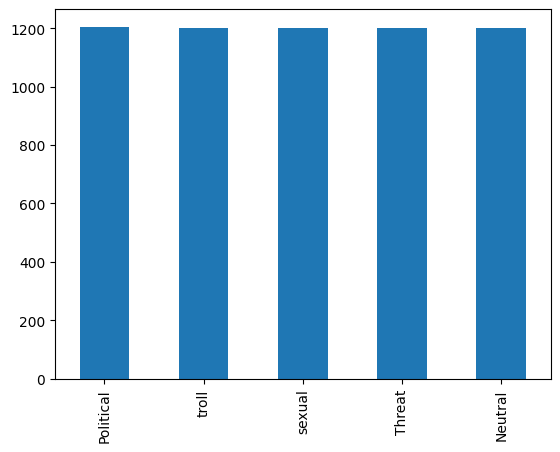

In [262]:
dataframe["Label"].value_counts().plot(kind="bar")
plt.show()

In [263]:
print(dataframe.isnull().sum())

Unnamed: 0     0
Description    0
Label          0
dtype: int64


# Removing the Unnamed 0 or 1st column

In [264]:
dataframe = dataframe.drop("Unnamed: 0", axis=1)
dataframe.head(10)

,Description,Label
0,ওই হালার পুত এখন কি মদ খাওয়ার সময় রাতের বেলা...,sexual
1,আপনার জন্ম প্রক্রিয়ার সময় আপনার মায়ের ভিতর কি ...,sexual
2,ধজভংগ দের আর ভায়াগ্রা লাগবো না। ধংস হোক এই সব ...,sexual
3,বোকাচোদা একটা।,sexual
4,তোর দেশে ফেরার অপেক্ষায় রইলাম। জেলে একটা কামরা...,sexual
5,বাংলাদেশ ফেসবুক ইজ বিনোদন,sexual
6,ক্ষমা করার মালিক উপরওয়ালা। উনি ক্ষমা করে দিলে ...,sexual
7,আপনি ক্ষমা চেয়েছেন। এটাই বড় কথা।ক্ষমা করার মাল...,sexual
8,নিজের রিভিউ বারানোর জন্যই জতো সব নাটক? ফালতু.....,sexual
9,আপনাদের সকলের কাছে একটা বিষয়ে অনুরোধ-দয়াকরে এই...,sexual


In [265]:
print(dataframe['Label'].isnull().sum())

0


# Converting Label classes to numerical value

In [266]:
label_mapping = {'sexual': 0, 'Neutral': 1, 'Political': 2, 'troll': 3, 'Threat': 4}
dataframe['Label'] = dataframe['Label'].map(label_mapping).astype(int)

class_names = [label for label, _ in sorted(label_mapping.items(), key=lambda x: x[1])]

In [267]:
dataframe.head()

,Description,Label
0,ওই হালার পুত এখন কি মদ খাওয়ার সময় রাতের বেলা...,0
1,আপনার জন্ম প্রক্রিয়ার সময় আপনার মায়ের ভিতর কি ...,0
2,ধজভংগ দের আর ভায়াগ্রা লাগবো না। ধংস হোক এই সব ...,0
3,বোকাচোদা একটা।,0
4,তোর দেশে ফেরার অপেক্ষায় রইলাম। জেলে একটা কামরা...,0


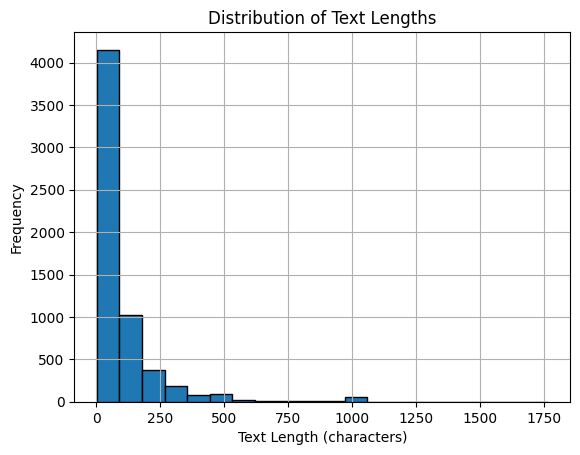

In [268]:
dataframe['Text_Length'] = dataframe['Description'].str.len()
dataframe.hist(column='Text_Length', bins=20, edgecolor='black')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.show()

# Dataset Cleaning

Cleaning the dataset by removing non-bengali characters.

In [269]:
import re

def clean_text(text):
    cleaned_text = re.sub(r'[^\u0980-\u09FF\s]', '', text)
    return cleaned_text

In [270]:
dataframe["Description_"] = dataframe["Description"].apply(clean_text)

# Checking cleaned text

In [271]:
import random

sample_size = 10
random_indices = random.sample(range(len(dataframe)), sample_size)

for idx in random_indices:
    original_text = dataframe.loc[idx, 'Description']
    cleaned_text = dataframe.loc[idx, 'Description_']

    print(f"Original Text: {original_text}")
    print(f"Cleaned Text:  {cleaned_text}")
    print("--*--" * 10)

Original Text: মুক্তি চাই ।
Cleaned Text:  মুক্তি চাই 
--*----*----*----*----*----*----*----*----*----*--
Original Text: সুন্দর হয়ছে
Cleaned Text:  সুন্দর হয়ছে
--*----*----*----*----*----*----*----*----*----*--
Original Text: জুতা কবির তুই নাস্তিক
Cleaned Text:  জুতা কবির তুই নাস্তিক
--*----*----*----*----*----*----*----*----*----*--
Original Text: হেতেরে দেহার পর মনটা কইতাছি এমন করি।
Cleaned Text:  হেতেরে দেহার পর মনটা কইতাছি এমন করি
--*----*----*----*----*----*----*----*----*----*--
Original Text: তাই নাকি । বাংলাদেশ এখন সকল জায়গায় ভাল খেলার যোগ্যতা রাখে সেটা ভারত কিংবা অস্ট্রেলিয়ার মত দেশেও । এটা তারা ইংলেন্ডই প্রমান করেছে।
Cleaned Text:  তাই নাকি  বাংলাদেশ এখন সকল জায়গায় ভাল খেলার যোগ্যতা রাখে সেটা ভারত কিংবা অস্ট্রেলিয়ার মত দেশেও  এটা তারা ইংলেন্ডই প্রমান করেছে
--*----*----*----*----*----*----*----*----*----*--
Original Text: খানকিরে দেখানো উচিৎ বাংলাদেশে সব ধর্মের লোক কতটা মিলেমিশে আছে।
Cleaned Text:  খানকিরে দেখানো উচিৎ বাংলাদেশে সব ধর্মের লোক কতটা মিলেমিশে আছে
--*----*----*----

In [272]:
tokenizer = BasicTokenizer()
test_text="চুলকাইতে মন চাইলে জাগা মত চুলকান পারলে ভারতের চ্যানেল গুলা বন্দ করেন নিজেদের ব্যার্থতা অন্যের উপর চাপিয়ে দিতে খুব ভাল লাগে"
test_token = tokenizer(test_text)
print(test_token)

['চুলকাইতে', 'মন', 'চাইলে', 'জাগা', 'মত', 'চুলকান', 'পারলে', 'ভারতের', 'চ্যানেল', 'গুলা', 'বন্দ', 'করেন', 'নিজেদের', 'ব্যার্থতা', 'অন্যের', 'উপর', 'চাপিয়ে', 'দিতে', 'খুব', 'ভাল', 'লাগে']


In [273]:
tokens = dataframe['Description_'].apply(lambda x: tokenizer(x))

# Binary & Multi Classification

In [274]:
X_bin = dataframe["Description_"]
y_bin = dataframe["Label"].apply(lambda x: 1 if x == 0 else 0)

X_multi = dataframe["Description_"]
y_multi = dataframe["Label"]

X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_bin, y_bin, test_size=0.2, random_state=42)
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multi, y_multi, test_size=0.2, random_state=42)

In [275]:
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_bin)

X_train_bin_seq = tokenizer.texts_to_sequences(X_train_bin)
X_test_bin_seq = tokenizer.texts_to_sequences(X_test_bin)

X_train_multi_seq = tokenizer.texts_to_sequences(X_train_multi)
X_test_multi_seq = tokenizer.texts_to_sequences(X_test_multi)

X_train_bin_pad = pad_sequences(X_train_bin_seq, maxlen=max_len, truncating='post')
X_test_bin_pad = pad_sequences(X_test_bin_seq, maxlen=max_len, truncating='post')

X_train_multi_pad = pad_sequences(X_train_multi_seq, maxlen=max_len, truncating='post')
X_test_multi_pad = pad_sequences(X_test_multi_seq, maxlen=max_len, truncating='post')

In [276]:
X_train_bin_tensor = torch.tensor(X_train_bin_pad, dtype=torch.long)
y_train_bin_tensor = torch.tensor(y_train_bin, dtype=torch.float32)
X_test_bin_tensor = torch.tensor(X_test_bin_pad, dtype=torch.long)
y_test_bin_tensor = torch.tensor(np.array(y_test_bin), dtype=torch.float32)

X_train_multi_tensor = torch.tensor(X_train_multi_pad, dtype=torch.long)
y_train_multi_tensor = torch.tensor(y_train_multi, dtype=torch.long)
X_test_multi_tensor = torch.tensor(X_test_multi_pad, dtype=torch.long)
y_test_multi_tensor = torch.tensor(np.array(y_test_multi), dtype=torch.long)

train_bin_data = TensorDataset(X_train_bin_tensor, y_train_bin_tensor)
test_bin_data = TensorDataset(X_test_bin_tensor, y_test_bin_tensor)
train_bin_loader = DataLoader(train_bin_data, batch_size=64, shuffle=True)
test_bin_loader = DataLoader(test_bin_data, batch_size=64, shuffle=False)

train_multi_data = TensorDataset(X_train_multi_tensor, y_train_multi_tensor)
test_multi_data = TensorDataset(X_test_multi_tensor, y_test_multi_tensor)
train_multi_loader = DataLoader(train_multi_data, batch_size=64, shuffle=True)
test_multi_loader = DataLoader(test_multi_data, batch_size=64, shuffle=False)


# LSTM MODEL

In [277]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        output = self.fc(lstm_out[:, -1, :])
        return output

In [278]:
vocab_size = 10000
embedding_dim = 50
hidden_dim = 50
output_dim_bin = 1
output_dim_multi = 5

lstm_model_bin = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim_bin)
lstm_model_multi = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim_multi)

criterion_bin = nn.BCEWithLogitsLoss()
criterion_multi = nn.CrossEntropyLoss()

optimizer_bin = optim.Adam(lstm_model_bin.parameters(), lr=0.001)
optimizer_multi = optim.Adam(lstm_model_multi.parameters(), lr=0.001)

num_epochs = 5

for epoch in range(num_epochs):
    lstm_model_bin.train()
    for inputs, labels in tqdm(train_bin_loader, desc=f'Epoch {epoch + 1}/Binary Train'):
        optimizer_bin.zero_grad()
        outputs = lstm_model_bin(inputs)
        loss = criterion_bin(outputs.squeeze(), labels)
        loss.backward()
        optimizer_bin.step()

    lstm_model_bin.eval()
    with torch.no_grad():
        all_preds_bin = []
        all_labels_bin = []
        for inputs, labels in tqdm(test_bin_loader, desc=f'Epoch {epoch + 1}/Binary Test'):
            outputs = lstm_model_bin(inputs)
            preds = torch.sigmoid(outputs.squeeze())
            all_preds_bin.extend(preds.tolist())
            all_labels_bin.extend(labels.tolist())

        accuracy = accuracy_score(all_labels_bin, [1 if p >= 0.5 else 0 for p in all_preds_bin])
        print(f'Epoch {epoch + 1}, Binary Accuracy: {accuracy * 100:.2f}%')

num_epochs = 5

for epoch in range(num_epochs):
    lstm_model_multi.train()
    for inputs, labels in tqdm(train_multi_loader, desc=f'Epoch {epoch + 1}/Multiclass Train'):
        optimizer_multi.zero_grad()
        outputs = lstm_model_multi(inputs)
        loss = criterion_multi(outputs, labels)
        loss.backward()
        optimizer_multi.step()

    lstm_model_multi.eval()
    with torch.no_grad():
        all_preds = []
        all_labels = []
        for inputs, labels in tqdm(test_multi_loader, desc=f'Epoch {epoch + 1}/Multiclass Test'):
            outputs = lstm_model_multi(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.tolist())

        accuracy = accuracy_score(all_labels, all_preds)
        print(f'Epoch {epoch + 1}, Multiclass Accuracy: {accuracy * 100:.2f}%')


Epoch 1/Binary Test: 100%|██████████| 19/19 [00:00<00:00, 24.54it/s]


Epoch 1, Binary Accuracy: 77.62%


Epoch 2/Binary Test: 100%|██████████| 19/19 [00:00<00:00, 29.31it/s]


Epoch 2, Binary Accuracy: 77.79%


Epoch 3/Binary Test: 100%|██████████| 19/19 [00:00<00:00, 28.47it/s]


Epoch 3, Binary Accuracy: 78.45%


Epoch 4/Binary Test: 100%|██████████| 19/19 [00:00<00:00, 28.03it/s]


Epoch 4, Binary Accuracy: 79.03%


Epoch 5/Binary Test: 100%|██████████| 19/19 [00:00<00:00, 48.85it/s]


Epoch 5, Binary Accuracy: 79.95%


Epoch 1/Multiclass Test: 100%|██████████| 19/19 [00:00<00:00, 49.04it/s]


Epoch 1, Multiclass Accuracy: 31.78%


Epoch 2/Multiclass Test: 100%|██████████| 19/19 [00:00<00:00, 49.14it/s]


Epoch 2, Multiclass Accuracy: 37.69%


Epoch 3/Multiclass Test: 100%|██████████| 19/19 [00:00<00:00, 48.56it/s]


Epoch 3, Multiclass Accuracy: 42.18%


Epoch 4/Multiclass Test: 100%|██████████| 19/19 [00:00<00:00, 37.41it/s]


Epoch 4, Multiclass Accuracy: 46.34%


Epoch 5/Multiclass Test: 100%|██████████| 19/19 [00:00<00:00, 49.70it/s]

Epoch 5, Multiclass Accuracy: 48.34%


# Reports

Binary Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.98      0.88       933
         1.0       0.70      0.18      0.29       269

    accuracy                           0.80      1202
   macro avg       0.75      0.58      0.59      1202
weighted avg       0.78      0.80      0.75      1202

Multiclass Classification Report:
              precision    recall  f1-score   support

      sexual       0.36      0.32      0.34       269
     Neutral       0.49      0.44      0.46       239
   Political       0.46      0.75      0.57       221
       troll       0.34      0.27      0.30       231
      Threat       0.80      0.67      0.73       242

    accuracy                           0.48      1202
   macro avg       0.49      0.49      0.48      1202
weighted avg       0.49      0.48      0.48      1202



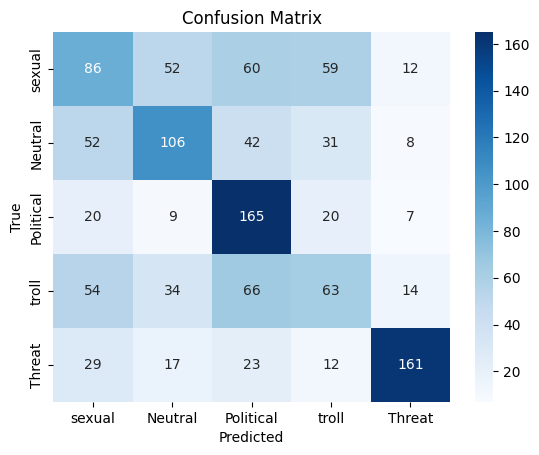

In [279]:
print("Binary Classification Report:")
print(classification_report(all_labels_bin, [1 if p >= 0.5 else 0 for p in all_preds_bin]))

print("Multiclass Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

lstm_conf_matrix_multi = confusion_matrix(all_labels, all_preds)

class_names = [label for label, _ in sorted(label_mapping.items(), key=lambda x: x[1])]
sns.heatmap(lstm_conf_matrix_multi, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# RNN Model

In [280]:
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        rnn_out, _ = self.rnn(embedded)
        output = self.fc(rnn_out[:, -1, :])
        output = self.sigmoid(output)
        return output

In [281]:
vocab_size = 10000
embedding_dim = 50
hidden_dim = 50
output_dim_bin = 1
output_dim_multi = 5

rnn_model_bin = RNNModel(vocab_size, embedding_dim, hidden_dim, output_dim_bin)
rnn_model_multi = RNNModel(vocab_size, embedding_dim, hidden_dim, output_dim_multi)

print(rnn_model_bin)

criterion_bin = nn.BCEWithLogitsLoss()
criterion_multi = nn.CrossEntropyLoss()

optimizer_bin = optim.Adam(rnn_model_bin.parameters(), lr=0.001)
optimizer_multi = optim.Adam(rnn_model_multi.parameters(), lr=0.001)

num_epochs = 5

for epoch in range(num_epochs):
    rnn_model_bin.train()
    for inputs, labels in tqdm(train_bin_loader, desc=f'Epoch {epoch + 1}/Binary Train'):
        optimizer_bin.zero_grad()
        outputs = rnn_model_bin(inputs)
        loss = criterion_bin(outputs.squeeze(), labels)
        loss.backward()
        optimizer_bin.step()

    rnn_model_bin.eval()
    with torch.no_grad():
        all_preds_bin = []
        all_labels_bin = []
        for inputs, labels in tqdm(test_bin_loader, desc=f'Epoch {epoch + 1}/Binary Test'):
            outputs = rnn_model_bin(inputs)
            preds = torch.sigmoid(outputs.squeeze())
            all_preds_bin.extend(preds.tolist())
            all_labels_bin.extend(labels.tolist())

        accuracy = accuracy_score(all_labels_bin, [1 if p >= 0.5 else 0 for p in all_preds_bin])
        print(f'Epoch {epoch + 1}, Binary Accuracy: {accuracy * 100:.2f}%')

num_epochs = 5

for epoch in range(num_epochs):
    lstm_model_multi.train()
    for inputs, labels in tqdm(train_multi_loader, desc=f'Epoch {epoch + 1}/Multiclass Train'):
        optimizer_multi.zero_grad()
        outputs = lstm_model_multi(inputs)
        loss = criterion_multi(outputs, labels)
        loss.backward()
        optimizer_multi.step()

    rnn_model_multi.eval()
    with torch.no_grad():
        all_preds = []
        all_labels = []
        for inputs, labels in tqdm(test_multi_loader, desc=f'Epoch {epoch + 1}/Multiclass Test'):
            outputs = rnn_model_multi(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.tolist())

        accuracy = accuracy_score(all_labels, all_preds)
        print(f'Epoch {epoch + 1}, Multiclass Accuracy: {accuracy * 100:.2f}%')

RNNModel(
  (embedding): Embedding(10000, 50)
  (rnn): RNN(50, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Epoch 1/Binary Test: 100%|██████████| 19/19 [00:00<00:00, 116.99it/s]


Epoch 1, Binary Accuracy: 22.38%


Epoch 2/Binary Test: 100%|██████████| 19/19 [00:00<00:00, 131.35it/s]


Epoch 2, Binary Accuracy: 22.38%


Epoch 3/Binary Test: 100%|██████████| 19/19 [00:00<00:00, 129.63it/s]


Epoch 3, Binary Accuracy: 22.38%


Epoch 4/Binary Test: 100%|██████████| 19/19 [00:00<00:00, 128.21it/s]


Epoch 4, Binary Accuracy: 22.38%


Epoch 5/Binary Test: 100%|██████████| 19/19 [00:00<00:00, 127.35it/s]


Epoch 5, Binary Accuracy: 22.38%


Epoch 1/Multiclass Test: 100%|██████████| 19/19 [00:00<00:00, 131.35it/s]


Epoch 1, Multiclass Accuracy: 20.38%


Epoch 2/Multiclass Test: 100%|██████████| 19/19 [00:00<00:00, 130.53it/s]


Epoch 2, Multiclass Accuracy: 20.38%


Epoch 3/Multiclass Test: 100%|██████████| 19/19 [00:00<00:00, 92.68it/s]


Epoch 3, Multiclass Accuracy: 20.38%


Epoch 4/Multiclass Test: 100%|██████████| 19/19 [00:00<00:00, 118.97it/s]


Epoch 4, Multiclass Accuracy: 20.38%


Epoch 5/Multiclass Test: 100%|██████████| 19/19 [00:00<00:00, 136.65it/s]

Epoch 5, Multiclass Accuracy: 20.38%


# Report

Binary Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       933
         1.0       0.22      1.00      0.37       269

    accuracy                           0.22      1202
   macro avg       0.11      0.50      0.18      1202
weighted avg       0.05      0.22      0.08      1202

Classification Report:
              precision    recall  f1-score   support

      sexual       0.23      0.16      0.19       269
     Neutral       0.28      0.15      0.20       239
   Political       0.17      0.35      0.23       221
       troll       0.22      0.31      0.26       231
      Threat       0.18      0.06      0.09       242

    accuracy                           0.20      1202
   macro avg       0.22      0.21      0.19      1202
weighted avg       0.22      0.20      0.19      1202



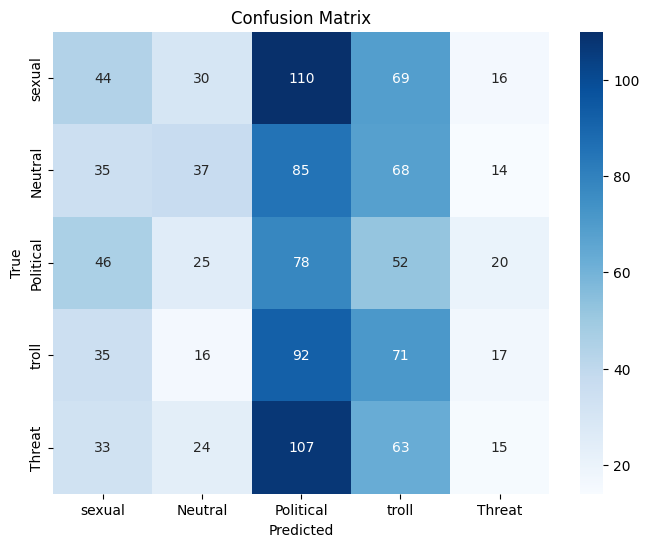

In [282]:
print("Binary Classification Report:")
print(classification_report(all_labels_bin, [1 if p >= 0.5 else 0 for p in all_preds_bin]))

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()